Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
from IPython.display import display, clear_output
import time

# **PREDICTION**

In [2]:
data = pd.read_csv('California_Fire_Incidents_2013-20.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AcresBurned          1633 non-null   float64
 1   Active               1636 non-null   bool   
 2   AdminUnit            1636 non-null   object 
 3   AirTankers           28 non-null     float64
 4   ArchiveYear          1636 non-null   int64  
 5   CalFireIncident      1636 non-null   bool   
 6   CanonicalUrl         1636 non-null   object 
 7   ConditionStatement   284 non-null    object 
 8   ControlStatement     105 non-null    object 
 9   Counties             1636 non-null   object 
 10  CountyIds            1636 non-null   object 
 11  CrewsInvolved        171 non-null    float64
 12  Dozers               123 non-null    float64
 13  Engines              191 non-null    float64
 14  Extinguished         1577 non-null   object 
 15  Fatalities           21 non-null     f

In [4]:
data.head()

,AcresBurned,Active,AdminUnit,AirTankers,ArchiveYear,CalFireIncident,CanonicalUrl,ConditionStatement,ControlStatement,Counties,...,Public,SearchDescription,SearchKeywords,Started,Status,StructuresDamaged,StructuresDestroyed,UniqueId,Updated,WaterTenders
0,257314.0,False,Stanislaus National Forest/Yosemite National Park,NaN,2013,True,/incidents/2013/8/17/rim-fire/,NaN,NaN,Tuolumne,...,True,The Rim Fire was east of Groveland along Highw...,"Rim Fire, Stanislaus National Forest, Yosemite...",2013-08-17T15:25:00Z,Finalized,NaN,NaN,5fb18d4d-213f-4d83-a179-daaf11939e78,2013-09-06T18:30:00Z,NaN
1,30274.0,False,USFS Angeles National Forest/Los Angeles Count...,NaN,2013,True,/incidents/2013/5/30/powerhouse-fire/,NaN,NaN,Los Angeles,...,True,The Powerhouse Fire burned in May and June 201...,"Powerhouse Fire, May 2013, June 2013, Angeles ...",2013-05-30T15:28:00Z,Finalized,NaN,NaN,bf37805e-1cc2-4208-9972-753e47874c87,2013-06-08T18:30:00Z,NaN
2,27531.0,False,CAL FIRE Riverside Unit / San Bernardino Natio...,NaN,2013,True,/incidents/2013/7/15/mountain-fire/,NaN,NaN,Riverside,...,True,The Mountain Fire burned in July 2013 off High...,"Mountain Fire, July 2013, Highway 243, Highway...",2013-07-15T13:43:00Z,Finalized,NaN,NaN,a3149fec-4d48-427c-8b2c-59e8b79d59db,2013-07-30T18:00:00Z,NaN
3,27440.0,False,Tahoe National Forest,NaN,2013,False,/incidents/2013/8/10/american-fire/,NaN,NaN,Placer,...,True,The American Fire burned in August 2013 off De...,"American Fire, August 2013, Deadwood Ridge, Fo...",2013-08-10T16:30:00Z,Finalized,NaN,NaN,8213f5c7-34fa-403b-a4bc-da2ace6e6625,2013-08-30T08:00:00Z,NaN
4,24251.0,False,Ventura County Fire/CAL FIRE,NaN,2013,True,/incidents/2013/5/2/springs-fire/,Acreage has been reduced based upon more accur...,NaN,Ventura,...,True,"The Springs Fire burned in May 2013, Southboun...","Springs Fire, May 2013, Highway 101, Camarillo...",2013-05-02T07:01:00Z,Finalized,6.0,10.0,46731fb8-3350-4920-bdf7-910ac0eb715c,2013-05-11T06:30:00Z,11.0


Fill missing/empty values

In [5]:
for col in data.columns:
    if data[col].dtype == 'object':
        data[col].fillna(data[col].mode()[0], inplace=True)
    else:
        data[col].fillna(data[col].median(), inplace=True)


C:\Users\Lester Greeks\AppData\Local\Temp\ipykernel_1076\314952444.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)
C:\Users\Lester Greeks\AppData\Local\Temp\ipykernel_1076\314952444.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

Categorizing Risks based on AcresBurned

In [6]:
data['FireRisk'] = np.where(data['AcresBurned'] <= 100, 'Low', np.where(data['AcresBurned'] <= 500, 'Medium', 'High'))

Splitting the dataset into training/test set

In [7]:
X = data[['Latitude', 'Longitude', 'CountyIds']]  # features
y = data['FireRisk']  # target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Converting strings to float and replacing the commas inbetween

In [8]:
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = X_train[col].str.replace(',', '').astype(float)
        X_test[col] = X_test[col].str.replace(',', '').astype(float)


Training the model

In [9]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Evaluating the model

In [10]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.49390243902439024


Fire Risk Predition based on Probability of Risk

In [11]:
def predict_fire_risk(model, data, county_ids):
    if isinstance(county_ids, str):
        county_ids = list(map(int, county_ids.split(',')))
    data['CountyIds'] = data['CountyIds'].apply(lambda x: ''.join(filter(str.isdigit, str(x))))
    try:
        data['CountyIds'] = data['CountyIds'].astype(int)
    except ValueError as e:
        print(f"Error converting 'CountyIds' to integer: {e}")
        invalid_rows = data[~data['CountyIds'].apply(lambda x: str(x).isdigit())]
        print("Rows with invalid CountyIds after cleaning:")
        print(invalid_rows)
        return
    print()
    for county_id in county_ids:
        print(f"\nCounty ID: {county_id}")
        county_data = data[data['CountyIds'] == county_id]
        if county_data.empty:
            print(f"No data available for County ID: {county_id}")
            continue
        features = ['Latitude', 'Longitude', 'CountyIds']
        county_data = county_data[features]
        print()
        print(f"County Data for County ID {county_id}:")
        print(county_data.head())
        print()
        probabilities = model.predict_proba(county_data)
        low_risk_threshold = 30
        high_risk_threshold = 70
        low_risk = probabilities[:, 0] * 100
        high_risk = probabilities[:, 1] * 100
        medium_risk = np.where((high_risk >= low_risk_threshold) & (high_risk < high_risk_threshold), high_risk, np.nan)
        avg_low_risk_percentage = np.nanmean(low_risk) if not np.isnan(low_risk).all() else 0.0
        avg_medium_risk_percentage = np.nanmean(medium_risk) if not np.isnan(medium_risk).all() else 0.0
        avg_high_risk_percentage = np.nanmean(high_risk) if not np.isnan(high_risk).all() else 0.0
        print()
        print(f"Low Risk: {avg_low_risk_percentage:.2f}%")
        print(f"Medium Risk: {avg_medium_risk_percentage:.2f}%")
        print(f"High Risk: {avg_high_risk_percentage:.2f}%")
        print()
        risk_df = pd.DataFrame({
            'Risk Level': ['Low Risk', 'Medium Risk', 'High Risk'],
            'Percentage': [avg_low_risk_percentage, avg_medium_risk_percentage, avg_high_risk_percentage]
        })
        risk_df.plot(x='Risk Level', y='Percentage', kind='bar', color=['blue', 'orange', 'red'], legend=False, figsize=(12, 6))
        plt.title(f"Average Fire Risk for County ID {county_id}")
        plt.ylabel("Risk Probability (%)")
        plt.ylim(0, 100)
        plt.show()


In [12]:
def check_non_numeric_countyids(data):
    non_numeric_countyids = data[~data['CountyIds'].apply(pd.to_numeric, errors='coerce').notna()]

check_non_numeric_countyids(data)


In [13]:
data = data.dropna(subset=['Latitude', 'Longitude'])


In [14]:
df = data[['CountyIds','Counties']]
county_dict = df.set_index('CountyIds')['Counties'].to_dict()
county_dict

{'55': 'Tuolumne',
 '19': 'Los Angeles',
 '33': 'Riverside',
 '31': 'Placer',
 '56': 'Ventura',
 '10': 'Fresno',
 '47': 'Siskiyou',
 '12': 'Humboldt',
 '52': 'Tehama',
 '45': 'Shasta',
 '37': 'San Diego',
 '15,56': 'Ventura',
 '49': 'Sonoma',
 '7': 'Contra Costa',
 '4': 'Butte',
 '54': 'Tulare',
 '42': 'Santa Barbara',
 '22': 'Mariposa',
 '33,': 'Riverside',
 '27': 'Monterey',
 '15': 'Kern',
 '9': 'El Dorado',
 '36': 'San Bernardino',
 '32': 'Plumas',
 '25': 'Modoc',
 '40': 'San Luis Obispo',
 '20': 'Madera',
 '14': 'Inyo',
 '28': 'Napa',
 '35': 'San Benito',
 '39': 'San Joaquin',
 '17': 'Lake',
 '1': 'Alameda',
 '11': 'Glenn',
 '57': 'Yolo',
 '9,34': 'Sacramento',
 '50': 'Stanislaus',
 '48': 'Solano',
 '24': 'Merced',
 '23': 'Mendocino',
 '18': 'Lassen',
 '3': 'Amador',
 '58': 'Yuba',
 '29': 'Nevada',
 '43': 'Santa Clara',
 '5': 'Calaveras',
 '41': 'San Mateo',
 '30': 'Orange',
 '49,48,17,6': 'Colusa',
 '28,17': 'Lake',
 '3,9': 'El Dorado',
 '53': 'Trinity',
 ',40': 'San Luis Obispo',

**Input Here**



County ID: 62

County Data for County ID 62:
       Latitude   Longitude  CountyIds
1421  32.573437 -116.658735         62


Low Risk: 73.54%
Medium Risk: 0.00%
High Risk: 24.93%



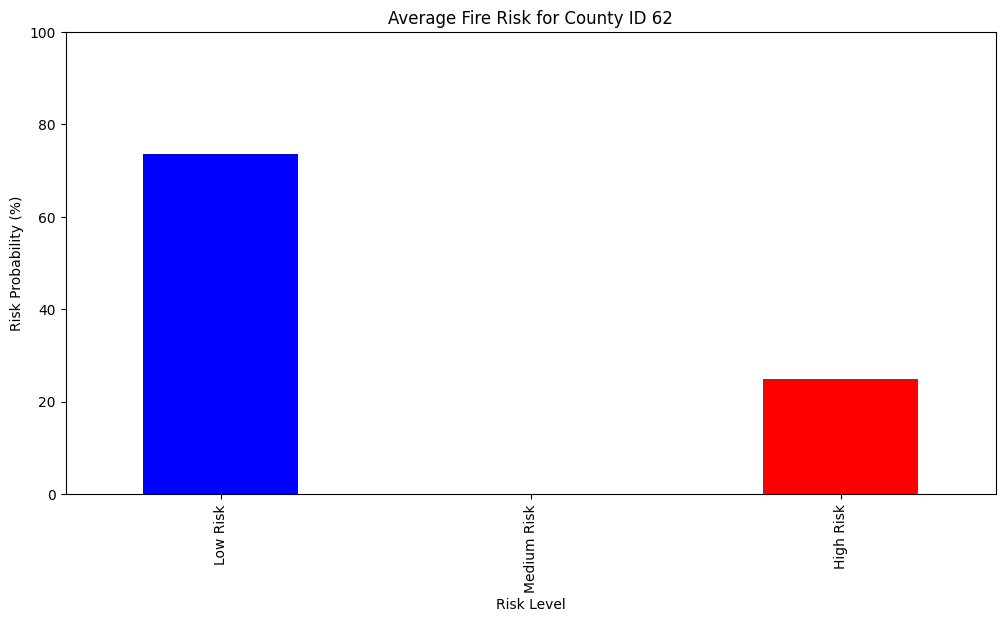


County ID: 37

County Data for County ID 37:
     Latitude   Longitude  CountyIds
11  32.954350 -116.473810         37
18  33.121110 -116.525790         37
20  33.341000 -117.309200         37
25  33.044580 -116.520900         37
52  32.710918 -116.746023         37


Low Risk: 23.02%
Medium Risk: 49.02%
High Risk: 51.10%



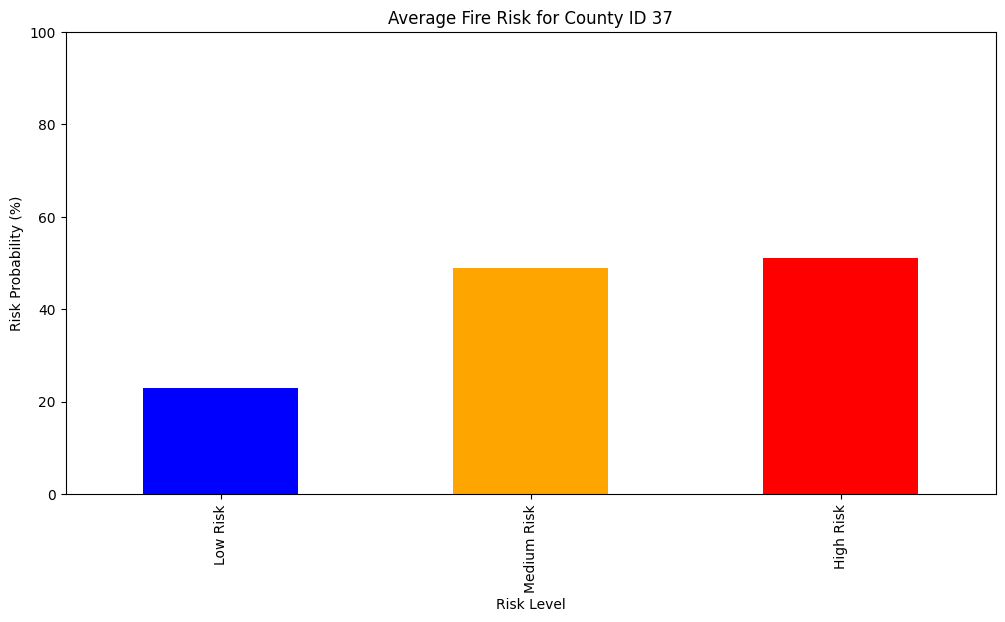

In [15]:
county_ids_input = input('Enter County ID(s) (comma-separated): ')
county_ids = list(map(int, county_ids_input.split(',')))
predict_fire_risk(model, data, county_ids)

Cleaning columns with numeric data

In [16]:
def clean_numeric_columns(data):
    data['CountyIds'] = pd.to_numeric(data['CountyIds'], errors='coerce')
    data['Latitude'] = pd.to_numeric(data['Latitude'], errors='coerce')
    data['Longitude'] = pd.to_numeric(data['Longitude'], errors='coerce')
    data['CountyIds'] = data['CountyIds'].fillna(data['CountyIds'].median())
    data['Latitude'] = data['Latitude'].fillna(data['Latitude'].mean())
    data['Longitude'] = data['Longitude'].fillna(data['Longitude'].mean())

    return data

Plotting the three risks using line plot

In [17]:
def plot_risk_lines_by_county(model, data):
    data = clean_numeric_columns(data)
    data['CountyIds'] = pd.to_numeric(data['CountyIds'], errors='coerce')
    data = data.dropna(subset=['CountyIds'])
    print(f"Data shape after cleaning: {data.shape}")
    features = ['Latitude', 'Longitude', 'CountyIds']
    county_data = data[features]
    print(f"County data shape: {county_data.shape}")
    if county_data.empty:
        print("No data left for prediction!")
        return
    probabilities = model.predict_proba(county_data)
    data['High Risk (%)'] = probabilities[:, 1] * 100
    avg_risk_by_county = data.groupby('CountyIds')['High Risk (%)'].mean().reset_index()
    avg_risk_by_county = avg_risk_by_county.sort_values(by='CountyIds')
    low_risk_threshold = 33
    high_risk_threshold = 66
    low_risk_counties = avg_risk_by_county[avg_risk_by_county['High Risk (%)'] < low_risk_threshold]
    medium_risk_counties = avg_risk_by_county[(avg_risk_by_county['High Risk (%)'] >= low_risk_threshold) &
                                               (avg_risk_by_county['High Risk (%)'] < high_risk_threshold)]
    high_risk_counties = avg_risk_by_county[avg_risk_by_county['High Risk (%)'] >= high_risk_threshold]
    low_risk_counties['x_index'] = range(len(low_risk_counties))
    medium_risk_counties['x_index'] = range(len(low_risk_counties), len(low_risk_counties) + len(medium_risk_counties))
    high_risk_counties['x_index'] = range(len(low_risk_counties) + len(medium_risk_counties), len(avg_risk_by_county))
    low_risk_offset = 0
    medium_risk_offset = 10
    high_risk_offset = 20
    plt.figure(figsize=(12, 6))
    plt.plot(low_risk_counties['x_index'], low_risk_counties['High Risk (%)'] + low_risk_offset,
             color='blue', marker='o', label='Low Risk Counties')
    plt.plot(medium_risk_counties['x_index'], medium_risk_counties['High Risk (%)'] + medium_risk_offset,
             color='orange', marker='o', label='Medium Risk Counties')
    plt.plot(high_risk_counties['x_index'], high_risk_counties['High Risk (%)'] + high_risk_offset,
             color='red', marker='o', label='High Risk Counties')
    label_offset = 0.1
    for i, row in low_risk_counties.iterrows():
        plt.text(row['x_index'] + label_offset, row['High Risk (%)'] + low_risk_offset,
                 f"{int(row['CountyIds'])}", fontsize=8, color='black', ha='center')
    for i, row in medium_risk_counties.iterrows():
        plt.text(row['x_index'] + label_offset, row['High Risk (%)'] + medium_risk_offset,
                 f"{int(row['CountyIds'])}", fontsize=8, color='black', ha='center')
    for i, row in high_risk_counties.iterrows():
        plt.text(row['x_index'] + label_offset, row['High Risk (%)'] + high_risk_offset,
                 f"{int(row['CountyIds'])}", fontsize=8, color='black', ha='center')
    plt.xticks(np.concatenate([low_risk_counties['x_index'], medium_risk_counties['x_index'], high_risk_counties['x_index']]),
               np.concatenate([low_risk_counties['CountyIds'], medium_risk_counties['CountyIds'], high_risk_counties['CountyIds']]),
               rotation=90, ha="right")
    plt.xlabel('County ID')
    plt.ylabel('High Risk Probability (%)')
    plt.title('Fire Risk by County (Low, Medium, and High)')
    plt.legend()
    plt.tight_layout()
    plt.show()


Data shape after cleaning: (1636, 38)
County data shape: (1636, 3)


C:\Users\Lester Greeks\AppData\Local\Temp\ipykernel_1076\2523326569.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_risk_counties['x_index'] = range(len(low_risk_counties))
C:\Users\Lester Greeks\AppData\Local\Temp\ipykernel_1076\2523326569.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medium_risk_counties['x_index'] = range(len(low_risk_counties), len(low_risk_counties) + len(medium_risk_counties))
C:\Users\Lester Greeks\AppData\Local\Temp\ipykernel_1076\2523326569.py:24: SettingWithCopyWar

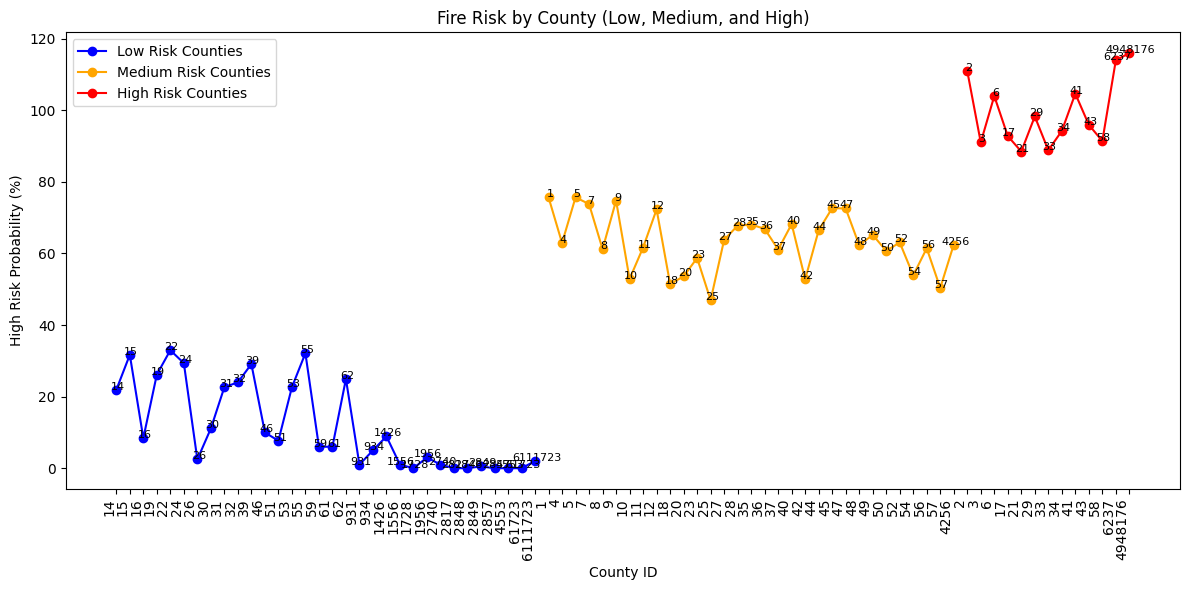

In [18]:
plot_risk_lines_by_county(model, data)

# **OFFLINE TEMPERATURE MONITORING PROTOTYPE FOR LIVE LIKE EXPERIENCE**

In [19]:
data2 = pd.read_csv('California_Temp_Conditions.csv')

In [20]:
data2

,Stn Id,Stn Name,CIMIS Region,Date,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Max Air Temp (F),Min Air Temp (F),Avg Air Temp (F),Max Rel Hum (%),Min Rel Hum (%),Avg Rel Hum (%),Dew Point (F),Avg Wind Speed (mph),Wind Run (miles),Avg Soil Temp (F)
0,2,FivePoints,San Joaquin Valley,01-01-2018,0.06,0.00,219,7.3,63.4,35.3,47.8,82,46,65.0,36.6,3.3,78.3,51.1
1,2,FivePoints,San Joaquin Valley,01-02-2018,0.04,0.00,127,7.4,59.8,37.7,47.2,80,52,67.0,36.7,3.1,74.5,51.3
2,2,FivePoints,San Joaquin Valley,01-03-2018,0.04,0.00,125,8.4,61.1,37.3,49.9,79,49,68.0,39.9,4.5,107.5,51.3
3,2,FivePoints,San Joaquin Valley,01-04-2018,0.07,0.01,219,11.6,69.2,48.7,56.8,94,52,74.0,48.5,5.8,140.2,53.0
4,2,FivePoints,San Joaquin Valley,01-05-2018,0.07,0.00,239,12.7,73.8,47.5,59.8,94,49,72.0,50.8,4.2,101.4,54.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128120,262,Linden,San Joaquin Valley,9/14/2020,0.14,0.00,420,15.4,84.3,53.7,66.3,95,39,70.0,56.2,3.4,81.7,69.4
128121,262,Linden,San Joaquin Valley,9/15/2020,0.15,0.00,430,15.1,86.8,49.6,66.0,96,31,69.0,55.7,2.7,64.2,69.0
128122,262,Linden,San Joaquin Valley,9/16/2020,0.15,0.00,445,16.2,89.0,53.6,68.0,97,30,69.0,57.6,3.3,78.2,69.0
128123,262,Linden,San Joaquin Valley,9/17/2020,0.16,0.00,447,16.6,88.1,53.3,70.4,97,35,65.0,58.3,3.3,78.1,69.5


Testing Map

In [21]:
lat = 36.7783
lon = -119.4179

# Initialize the map centered around San Joaquin Valley
m = folium.Map(location=[lat, lon], zoom_start=14)

# Add a marker for San Joaquin Valley
folium.Marker(
    location=[lat, lon],
    popup="San Joaquin Valley",
    icon=folium.Icon(color='blue')
).add_to(m)

# Save map to an HTML file
m.save("san_joaquin_valley_map.html")

# Display the map (works in Jupyter Notebooks or similar environments)
m


Wildfire risk assessment on new dataset

In [22]:
def assess_wildfire_risk(row):
    low_precip = row['Precip (in)'] < 0.1
    high_solar_radiation = row['Sol Rad (Ly/day)'] > 400
    high_avg_temp = row['Avg Air Temp (F)'] > 75
    high_max_temp = row['Max Air Temp (F)'] > 85
    low_avg_humidity = row['Avg Rel Hum (%)'] < 30
    low_min_humidity = row['Min Rel Hum (%)'] < 20
    low_dew_point = row['Dew Point (F)'] < 40
    high_wind_speed = row['Avg Wind Speed (mph)'] > 15
    high_wind_run = row['Wind Run (miles)'] > 200

    risk_score = sum([
        low_precip, high_solar_radiation, high_avg_temp, high_max_temp,
        low_avg_humidity, low_min_humidity, low_dew_point,
        high_wind_speed, high_wind_run
    ])

    if risk_score >= 4:
        return 'High Risk'
    elif risk_score >= 2:
        return 'Moderate Risk'
    else:
        return 'Low Risk'

Available locations to explore

In [23]:
print(data2['CIMIS Region'].unique())

['San Joaquin Valley' 'Sacramento Valley' 'Sierra Foothill' 'Bishop'
 'Imperial/Coachella Valley' 'Northeast Plateau' 'Los Angeles Basin'
 'San Francisco Bay' 'Central Coast Valleys' 'South Coast Valleys'
 'North Coast Valleys' 'Monterey Bay' 'San Bernardino'
 'Eastern Sierra Basin & Range']


Interpreting a live like map experience for wildfire assessment

In [26]:
geolocator = Nominatim(user_agent="wildfire_heatmap")

#to get latitude and longitude for a city
def geocode_city(city):
    try:
        location = geolocator.geocode(city)
        if location:
            return location.latitude, location.longitude
    except Exception as e:
        print(f"Error geocoding {city}: {e}")
    return None, None

heat_data = []

regions_input = input("Enter the region(s) to assess (separate by commas for multiple regions): ").strip()
regions = [region.strip() for region in regions_input.split(',')]

region_found = False

for region in regions:
    if region in data2['CIMIS Region'].unique():
        region_found = True
        print(f"\nProcessing wildfire risk for region: {region}")
        region_data = data2[data2['CIMIS Region'] == region]
        #to update the map
        lat, lon = geocode_city(region)
        m = folium.Map(location=[lat, lon], zoom_start=18)
        for index, row in region_data.iterrows():
            risk = assess_wildfire_risk(row)
            print(f"{index}    {region}     {row['Precip (in)']}    {row['Sol Rad (Ly/day)']}     {row['Avg Air Temp (F)']}   {row['Max Air Temp (F)']}   {row['Avg Rel Hum (%)']}   {row['Min Rel Hum (%)']}  {row['Dew Point (F)']}    {row['Avg Wind Speed (mph)']}     {row['Wind Run (miles)']}     {risk}")
            data2.at[index, 'Wildfire Risk'] = risk
            lat, lon = geocode_city(row['CIMIS Region'])
            if lat and lon:
                heat_data.append([lat, lon, 1 if risk == 'Low Risk' else (2 if risk == 'Moderate Risk' else 3)])
                folium.Marker(
                    location=[lat, lon],
                    popup=f"{row['CIMIS Region']} - {risk}",
                    icon=folium.Icon(color='red' if risk == 'High Risk' else 'orange' if risk == 'Moderate Risk' else 'green')
                ).add_to(m)
            clear_output(wait=True)
            display(m)
            time.sleep(1)
        if heat_data:
            HeatMap(heat_data).add_to(m)
    else:
        print(f"\nRegion '{region}' not found in data!")

if not region_found:
    print("\nNo Region Found!")

KeyboardInterrupt: 